# Science without appropriate documentation is not science.





# Inital setup



In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID
Paris_data_id = "1RrDlcpTXBPFUtdFkE70E-iTsct5VngIb"
Paris_data_name = "Paris 05 June 2019.csv"
downloaded = drive.CreateFile({'id': Paris_data_id})
downloaded.GetContentFile(Paris_data_name)

# Download a file based on its file ID.
London_data_id = "1h13-5h9TfCUO3BFuC4cYVyz9W2XKfqyL"
London_data_name = "London 05 June 2019.csv"
downloaded = drive.CreateFile({'id': London_data_id})
downloaded.GetContentFile(London_data_name)


# Download a file based on its file ID.
Listing_data_id = "16BBhwZLzCeZMVu_pexrUtCkEXPTvn-x5"
Listing_data = "listings.csv"
downloaded = drive.CreateFile({'id': Listing_data_id})
downloaded.GetContentFile(Listing_data)


# Download a file based on its file ID.
Calender_data_id = "10Fri_UMYp5EF8I_HlIrywIZ_HjDUVWUA"
Calender_data = "calendar.csv"
downloaded = drive.CreateFile({'id': Calender_data_id})
downloaded.GetContentFile(Calender_data)


# Ignore IPythonNoteook Warnings
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 993kB 2.8MB/s 


**Libraries load**

In [0]:
from scipy.stats import anderson
from scipy.stats import ttest_ind
import    pandas     as pd
import    numpy      as np
import    matplotlib as mp
import    time
from sklearn.preprocessing import MinMaxScaler

# 1. Rapid Data Visualisation and Prototyping

**(a)** **Distribution of annual income**.  

The first thing to test out in any dataset is to find out the distribution of data. Here we are trying to find out the distribution of annual income for hosts. 

First we preprocessed the data by merging listing and calender. Then we calculated the annual income for each host.     

In [0]:
listing_fields = ['id', 'host_id']
calender_fields = ['listing_id','price']

Listings = pd.read_csv( Listing_data, index_col=False, usecols=listing_fields )
Calendar = pd.read_csv( Calender_data, index_col=False, usecols=calender_fields )

df_barlin = pd.merge(Listings, Calendar, how='inner', left_on = 'id', right_on = 'listing_id')
df_barlin = df_barlin.dropna()

df_barlin['price'] = df_barlin['price'].str[1:]
df_barlin['price'] = df_barlin['price'].str.replace(',', '')
df_barlin['price'] = df_barlin['price'].astype(float)
df_barlin = df_barlin.groupby(['host_id'])['price'].sum().reset_index()

print(df_barlin.head())


   host_id    price
0     2217  50503.0
1     3718  19800.0
2     4108   8058.0
3    10966  19373.0
4    11015   3442.0


Using tableau we created a histogram showing the distribution of annual income among hosts. We used a income/price bin size of 56k. Histogram shows that 8,951 hosts fall inside the 0 to 56k annual income bin. Where the total number of hosts are 9,374.  


![alt text](https://drive.google.com/uc?id=1H_l0nIXmcAo85-R4NJipLfIUE_mL8qse)

**(c) Anomaly detection**

Real world data are has anomalies. Airbnb dataset is also one of them. When we first plotted the distribution of income for hosts we thought there might be anomaly in prices. They might be due to human data entry error or miscalculation. 

To find out any anomalies we created a boxplot of price. Found out that there are several outliers. These values that are far away from other data values, can strongly affect results.


![](https://drive.google.com/uc?id=1Y03jZzWJBJgZRE_VMxA7kK8ijn6fEWwI)



# 2. Rank the Berlin listings

A classical problem for any platform website with listings is to rank your offering in the search page in a way that maximises the probability of your listings being sold. Airbnb shows its users listings which he/she is most likely to click. 

Airbnb use a combination of experience features, user features and query features. User features and query features are not public information. So here we will try to rank airbnb listings based on experience features.



**Lets start**


To keep the user experience simple Airbnb lets an user find a suitable host with only 3 information. Name of the city, checkin checkout and number of guest. User fills in these 3 information and a number of listings is shown. 

So host ranking is a very important part of their success. Ranking is a very interesting problem and can get very complex over time. So it is better to start off small and improve the ranking algorithm phase by phase.

Firstly we should check of features that we think might persuade a user to rent a listing. For example listings with bookings more than 1000 will rank higher, higher average review rating will rank higher, listings with lower prices will rank higher. We will deploy this model into production and keep user engagement to this ranked data in the database. Update the model periodicly and at the same time store user interaction data. We can use A/B testing to show different users different listings suggested by different model. This data will enable us to create user personalised model and at the same time tune for other parameters which cannot be handcrafted from experience.

Next phase can be to improve our ranking algorithm from real user data. We can store per booking information and review ratings related to that to improve our model even further. Features such as booked home location and user location, trip dates, trip length, number of guests, price , type of trip: family, business, clicks on listings, first trip or returning to location,  Domestic / International trip, Lead days, review, ratings, user location.  

We can use language processing to build word cloud from user review data, sentiment analysis and prioritise model toward what user want regionally.    

**Scope of study**

In this study I will try to build a simple holistic multivariate model that will show listing suggestions based on price, average number of reviews and number of bookings in a month.     

**Version 1**

First lets build the model for only one feature. Which is price. If price is low then it is more likely a user will be more interested.  

In [0]:
# Dataset load
Listings = pd.read_csv( Listing_data, index_col=False )

# Show features 
Listings.head()


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,"This is my home, not a hotel. I rent out occas...","Close to U-Bahn U8 and U2 (metro), Trams M12, ...","Simple kitchen/cooking, refrigerator, microwav...",Always available,"No parties No events No pets No smoking, not e...",NaN,NaN,https://a0.muscache.com/im/pictures/260fd609-7...,NaN,2217,https://www.airbnb.com/users/show/2217,Ian,2008-08-18,"Key Biscayne, Florida, United States",Believe in sharing economy.,within an hour,96%,NaN,t,https://a0.muscache.com/im/pictures/21428a22-4...,https://a0.muscache.com/im/pictures/21428a22-4...,Mitte,4.0,4.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Berlin, Berlin, Germany",Mitte,Brunnenstr. Süd,...,2.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",NaN,$60.00,NaN,NaN,$200.00,$30.00,1,$28.00,4,1125,3 months ago,t,0,21,51,141,2018-11-07,118,2016-04-11,2018-10-28,93.0,10.0,9.0,10.0,10.0,10.0,9.0,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,NaN,Within walking distance you'll find the S-Bahn...,Außer deinem Zimmer kannst du noch die Küche u...,NaN,NaN,NaN,NaN,https://a0.muscache.com/im/pictures/97d4f6e8-1...,NaN,2986,https://www.airbnb.com/users/show/2986,Michael,2008-09-16,"Berlin, Berlin, Germany",Living with my wife in Berlin. Like travellin...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/50434955-1...,https://a0.muscache.com/im/pictures/50434955-1...,Prenzlauer Berg,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Berlin, Berlin, Germany",NaN,Prenzlauer Berg Nordwest,...,1.0,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",NaN,$17.00,NaN,NaN,$0.00,$0.00,1,$0.00,2,40,7 weeks ago,t,0,0,0,0,2018-11-07,6,2018-07-04,2018-10-01,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,NaN,NaN,f,f,flexible,f,f,1,1.42
2,3176,https://www.airbnb.com/rooms/3176,20181107122246,2018-11-07,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,1st floor (68m2) apartment on Kollwitzplatz/ P...,This beautiful first floor apartment is situa...,none,The neighbourhood is famous for its variety of...,We welcome FAMILIES and cater especially for y...,"We are 5 min walk away from the tram M2, whic...",The apartment will be entirely yours. We are c...,Feel free to ask any

We dont need all those features. so lets remove some of them. Amenites are important but is in json format. We can deal with it later. We should never ever json encode stuff into a relational table no matter how much postgres helps you index and do queries on them. They are a total headache.  

In [0]:
# define the columns we want to keep
columns_to_keep = ['property_type', 'room_type', 'accommodates', 'bathrooms',
                   'bedrooms', 'bed_type', 'price', 'extra_people', 
                   'guests_included', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

Listings_feature_selected = Listings[columns_to_keep]
print( Listings_feature_selected )

        property_type  ...          cancellation_policy
0          Guesthouse  ...  strict_14_with_grace_period
1           Apartment  ...                     flexible
2           Apartment  ...  strict_14_with_grace_period
3           Apartment  ...  strict_14_with_grace_period
4           Apartment  ...                     moderate
5           Apartment  ...  strict_14_with_grace_period
6           Apartment  ...  strict_14_with_grace_period
7           Apartment  ...  strict_14_with_grace_period
8           Apartment  ...  strict_14_with_grace_period
9         Condominium  ...  strict_14_with_grace_period
10          Apartment  ...  strict_14_with_grace_period
11               Loft  ...  strict_14_with_grace_period
12          Apartment  ...  strict_14_with_grace_period
13          Apartment  ...  strict_14_with_grace_period
14          Apartment  ...  strict_14_with_grace_period
15        Condominium  ...  strict_14_with_grace_period
16          Apartment  ...  strict_14_with_grace

 **Preprocessing**
 
 Some basic preprocessing will do.
 

1.   One hot vector property type, room type, bed_type
2.   Remove $ and , from price
3.   Change t, f to 1 and 0
4.   Normalize the data
5.   Remove rows with missing values

TODO: Use sklearn preprocessing to improve code.




In [0]:
def preprocessing(Listings_feature_selected):
  Listings_feature_selected = Listings_feature_selected.dropna()

  # Get one hot encoding of columns
  property_type           = pd.get_dummies(Listings_feature_selected['property_type'])
  room_type               = pd.get_dummies(Listings_feature_selected['room_type'])
  cancellation_policy     = pd.get_dummies(Listings_feature_selected['cancellation_policy'])
  bed_type                = pd.get_dummies(Listings_feature_selected['bed_type'])


  # Drop column B as it is now encoded
  Listings_feature_selected = Listings_feature_selected.drop('property_type',axis = 1)
  Listings_feature_selected = Listings_feature_selected.drop('room_type',axis = 1)
  Listings_feature_selected = Listings_feature_selected.drop('cancellation_policy',axis = 1)
  Listings_feature_selected = Listings_feature_selected.drop('bed_type',axis = 1)


  # Join the encoded list
  Listings_feature_selected = Listings_feature_selected.join(property_type)
  Listings_feature_selected = Listings_feature_selected.join(room_type)
  Listings_feature_selected = Listings_feature_selected.join(cancellation_policy)
  Listings_feature_selected = Listings_feature_selected.join(bed_type)

  Listings_feature_selected['price'] = Listings_feature_selected['price'].str[1:]
  Listings_feature_selected['price'] = Listings_feature_selected['price'].str.replace(',', '')
  Listings_feature_selected['price'] = Listings_feature_selected['price'].astype(float)

  Listings_feature_selected['extra_people'] = Listings_feature_selected['extra_people'].str[1:]
  Listings_feature_selected['extra_people'] = Listings_feature_selected['extra_people'].str.replace(',', '')
  Listings_feature_selected['extra_people'] = Listings_feature_selected['extra_people'].astype(float)

  Listings_feature_selected['instant_bookable'] = Listings_feature_selected['instant_bookable'].str.replace('t', '1')
  Listings_feature_selected['instant_bookable'] = Listings_feature_selected['instant_bookable'].str.replace('f', '0')
  Listings_feature_selected['instant_bookable'] = Listings_feature_selected['instant_bookable'].astype(float)

  if 'host_is_superhost' in Listings_feature_selected: 
    Listings_feature_selected['host_is_superhost'] = Listings_feature_selected['host_is_superhost'].str.replace('t', '1')
    Listings_feature_selected['host_is_superhost'] = Listings_feature_selected['host_is_superhost'].str.replace('f', '0')
    Listings_feature_selected['host_is_superhost'] = Listings_feature_selected['host_is_superhost'].astype(float)
    
    indexNames = Listings_feature_selected[ (Listings_feature_selected['price'] >= 100) ].index
    Listings_feature_selected.drop(indexNames , inplace=True)

  Listings_feature_selected['is_business_travel_ready'] = Listings_feature_selected['is_business_travel_ready'].str.replace('t', '1')
  Listings_feature_selected['is_business_travel_ready'] = Listings_feature_selected['is_business_travel_ready'].str.replace('f', '0')
  Listings_feature_selected['is_business_travel_ready'] = Listings_feature_selected['is_business_travel_ready'].astype(float)


  scaler = MinMaxScaler()
  Listings_feature_selected[Listings_feature_selected.columns] = scaler.fit_transform(Listings_feature_selected[Listings_feature_selected.columns])

  return Listings_feature_selected
   
  
Listings_scaled = preprocessing(Listings_feature_selected);

**Methodology**


Lets start building the model. **First lets start with the price. The listing with the lowest price has the highest probability to be bought and hence should be ranked first.** Now let’s generate some fake user events based on this data. Each user will have a number of positive and negative events associated to them. A positive event is one where the user booked the listing. A negative event is one where the user saw the listing but decided to not book.

In [0]:
# Lets artificially define buy probability based on price

Listings_scaled["buy_probability"] = 1 - Listings_scaled["price"]
print(Listings_scaled.head())

   accommodates  bathrooms  bedrooms  ...  Pull-out Sofa  Real Bed  buy_probability
0      0.133333   0.117647  0.083333  ...            0.0       1.0         0.993333
1      0.066667   0.117647  0.083333  ...            0.0       1.0         0.998111
2      0.200000   0.117647  0.083333  ...            0.0       1.0         0.990000
3      0.066667   0.117647  0.083333  ...            1.0       0.0         0.997111
4      0.066667   0.117647  0.083333  ...            0.0       1.0         0.995333

[5 rows x 55 columns]


Looks like there are some outliers in price. most of the prices are well under 0.1. Lets handle that. We can see that the highest price is $10000. lets create a basic boxplot and remove outliers. This does not mean these listings cant be used. When a personalised ranking is implemented, All the prices can be included. If the user data suggests the user is on a holiday tour/family trip/business trip price does not matter usually. So in the future we can work with that. For now for simplicity we are excluding those listings.  

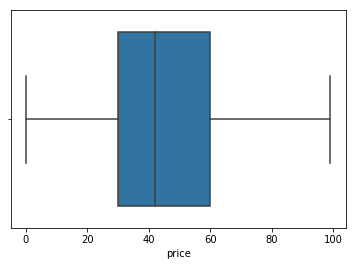

In [0]:
import seaborn as sns
from scipy import stats

Listings_feature_selected = Listings[columns_to_keep]
Listings_feature_selected['price'] = Listings_feature_selected['price'].str[1:]
Listings_feature_selected['price'] = Listings_feature_selected['price'].str.replace(',', '')
Listings_feature_selected['price'] = Listings_feature_selected['price'].astype(float)


# delete all rows for which column 'Age' has value greater than 30 and Country is India 
indexNames = Listings_feature_selected[ (Listings_feature_selected['price'] >= 100) ].index
Listings_feature_selected.drop(indexNames , inplace=True)

sns.boxplot(x=Listings_feature_selected['price'])

Listings_feature_selected['price'] = Listings_feature_selected['price'].astype(str)


In [0]:
Listings_feature_selected = preprocessing(Listings_feature_selected)
Listings_feature_selected["buy_probability"] = 1 - Listings_feature_selected["price"] * 1

Now lets generate some fake user events based on the this data. Each user will have a number of positive and negative events associated with them. Positive event means user booked the listing where negative means user saw the listing but did not book.  

In [0]:
class User:
    def __init__(self, id):
        self.id = id
        self.positive = []
        self.negative = []
        
    def add_positive(self, movie_id):
        self.positive.append(movie_id)
    
    def add_negative(self, movie_id):
        self.negative.append(movie_id)
    
    def get_positive(self):
        return self.positive
    
    def get_negative(self):
        return self.negative

Finally lets build the fake eventgenerator class. Lets create 1000 users that will open 20 listings. Real world data will be far different. But same principal applies to real life. We are generating a dataset depending on the holistic function we described earliar. it has listings and if a user booked the listing or not (outcome).  

In [0]:

np.random.seed(1)
class EventsGenerator:

    NUM_OF_OPENED_LISTINGS_PER_USER = 20
    NUM_OF_USERS = 1000

    def __init__(self, learning_data, buy_probability):
        self.learning_data = learning_data
        print(learning_data)
        self.buy_probability = buy_probability
        self.users = []
        for id in range(1, self.NUM_OF_USERS):
            self.users.append(User(id))

    def run(self):
        for user in self.users:
            opened_listing = \
                np.random.choice(self.learning_data.index.values,
                                 self.NUM_OF_OPENED_LISTINGS_PER_USER)
            self.__add_positives_and_negatives_to(user, opened_listing)
        return self.__build_events_data()

    def __add_positives_and_negatives_to(self, user, opened_listing):
        for listing_id in opened_listing:
            if np.random.binomial(1,
                                  self.buy_probability.loc[listing_id]):
                user.add_positive(listing_id)
            else:
                user.add_negative(listing_id)

    def __build_events_data(self):
        events_data = []

        for user in self.users:
            for positive_id in user.get_positive():
                tmp = self.learning_data.loc[positive_id].to_dict()
                tmp['outcome'] = 1
                events_data += [tmp]

            for negative_id in user.get_negative():
                tmp = self.learning_data.loc[negative_id].to_dict()
                tmp['outcome'] = 0
                events_data += [tmp]

        return pd.DataFrame(events_data)			

In [0]:
events_data = EventsGenerator( Listings_feature_selected.drop('buy_probability', axis=1), Listings_feature_selected['buy_probability'] ).run()
events_data["outcome"]


       accommodates  bathrooms  bedrooms  ...  Futon  Pull-out Sofa  Real Bed
0          0.133333   0.117647  0.111111  ...    0.0            0.0       1.0
1          0.066667   0.117647  0.111111  ...    0.0            0.0       1.0
2          0.200000   0.117647  0.111111  ...    0.0            0.0       1.0
3          0.066667   0.117647  0.111111  ...    0.0            1.0       0.0
4          0.066667   0.117647  0.111111  ...    0.0            0.0       1.0
6          0.066667   0.117647  0.000000  ...    0.0            0.0       1.0
8          0.266667   0.117647  0.111111  ...    0.0            0.0       1.0
9          0.066667   0.117647  0.111111  ...    0.0            0.0       1.0
12         0.200000   0.117647  0.111111  ...    0.0            0.0       1.0
13         0.200000   0.117647  0.222222  ...    0.0            0.0       1.0
15         0.200000   0.117647  0.111111  ...    0.0            0.0       1.0
16         0.200000   0.294118  0.222222  ...    0.0            

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
19950    1
19951    1
19952    0
19953    0
19954    0
19955    0
19956    0
19957    0
19958    0
19959    0
19960    1
19961    1
19962    1
19963    1
19964    1
19965    1
19966    1
19967    1
19968    1
19969    1
19970    1
19971    0
19972    0
19973    0
19974    0
19975    0
19976    0
19977    0
19978    0
19979    0
Name: outcome, Length: 19980, dtype: int64

We have our fake user dataset who booked the 

In [0]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = prediction_function(model, X_train)
    print('train precision: ' + str(precision_score(y_train, y_train_pred)))
    print('train recall: ' + str(recall_score(y_train, y_train_pred)))
    print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))
    y_test_pred = prediction_function(model, X_test)
    print('test precision: ' + str(precision_score(y_test, y_test_pred)))
    print('test recall: ' + str(recall_score(y_test, y_test_pred)))
    print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    
    return model
			

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( events_data.drop('outcome', axis=1), events_data["outcome"], test_size=0.30, random_state=55 )


def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]
  
from sklearn import tree
model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)


train precision: 0.9330130771283693
train recall: 0.8498845265588915
train accuracy: 0.8758043758043758
test precision: 0.8422337503814464
test recall: 0.7845366685616828
test accuracy: 0.7872872872872873


**Version 2**

Now lets change our simple learning function a bit. We will add number of reviews, superhost status to our holistic ranking function. If a host has more reviews and more rating he will be ranked higher, If a host is a superhost he will be ranked higher. Rest of the feature we will leave to the learning algorithm. 

We will prioritise price first then superhost. Review scores and number of reviews after that. 

In [0]:
# define the columns we want to keep
columns_to_keep = ['property_type', 'room_type', 'accommodates', 'bathrooms',
                   'bedrooms', 'bed_type', 'price', 'extra_people', 
                   'guests_included', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', "host_is_superhost","number_of_reviews", 
                   "review_scores_rating"]

Listings_feature_selected = Listings[columns_to_keep]
print( Listings_feature_selected )


Listings_scaled = preprocessing(Listings_feature_selected)
Listings_scaled["buy_probability"] = 1 - Listings_scaled["price"] + (Listings_scaled["host_is_superhost"] * .1) + (Listings_scaled["review_scores_rating"] * .1) + (Listings_scaled["number_of_reviews"] * .05)   

scaler = MinMaxScaler()
Listings_scaled[["buy_probability"]] = scaler.fit_transform(Listings_scaled[["buy_probability"]])

events_data = EventsGenerator( Listings_scaled.drop('buy_probability', axis=1), Listings_scaled['buy_probability'] ).run()
events_data["outcome"]


model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)


        property_type        room_type  ...  number_of_reviews  review_scores_rating
0          Guesthouse  Entire home/apt  ...                118                  93.0
1           Apartment     Private room  ...                  6                 100.0
2           Apartment  Entire home/apt  ...                143                  92.0
3           Apartment     Private room  ...                 25                  88.0
4           Apartment     Private room  ...                197                  96.0
5           Apartment  Entire home/apt  ...                  6                 100.0
6           Apartment  Entire home/apt  ...                 23                  93.0
7           Apartment     Private room  ...                  0                   NaN
8           Apartment  Entire home/apt  ...                 48                  94.0
9         Condominium     Private room  ...                279                  96.0
10          Apartment  Entire home/apt  ...                223   

**Results and Limitations**


Our results show that test accuracy is 78%. All ranking systems have limitations. This simple approch also have some. 

1.   Firstly, We removed most expensive listings as outliers. this will cause the listings to show up at the bottom
2.   If price is very low but facilities are none this ranking system will for some times show those listings on the top. But over time ranking system will learn and adapt to user events. So need a periodic model rerun backed with some datawarehouse etl.  



#  3. London, United Kingdom vs Paris, France

**(a) Yearly visitors in London and paris**

In 2018, according to wikipedia [2, 3], London attracted 20M+ tourists, whereas there were 18M in Paris. There is a clear difference between two cities. We want to see how much of that people stayed in Airbnb. 

We have a comparetive market analysis data from 5th june 2019. 

In [0]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
fields = ['id']

London = pd.read_csv( London_data_name, usecols= fields )
Paris = pd.read_csv( Paris_data_name, usecols= fields )
Barlin = pd.read_csv( Listing_data, usecols= fields )

Calender = pd.read_csv( Calender_data )

Paris.head(5)
Calender.head(2)


df_paris = pd.merge(Paris, Calender, how='inner', left_on = 'id', right_on = 'listing_id')
df_london = pd.merge(London, Calender, how='inner', left_on = 'id', right_on = 'listing_id')


df_barlin = pd.merge(Barlin, Calender, how='inner', left_on = 'id', right_on = 'listing_id')

print(df_barlin.count())
print(Calender.count())


id            8231480
listing_id    8231480
date          8231480
available     8231480
price         1800841
dtype: int64
listing_id    8231480
date          8231480
available     8231480
price         1800841
dtype: int64


Okay our calender dataset is from barlin. We dont have paris or london data. lets see what is the timeline of this barlin calender data.

In [0]:
print(df_barlin['date'].min())
print(df_barlin['date'].max())

2018-11-07
2019-11-08


Here we have 1 year data from visitors in barlin. Airbnb guests stayed an average of 3.5 nights [4] and Today Berlin attracts 13.5 million visitors a year [5]. Also market share of airbnb is between 3% to 4% according to a study conducted by et     

In [0]:
# We have 1800841 unique sales in 2018-19 in barlin

berlin_count = df_barlin["price"].count()

# If a user average stay is 3.5 nights then estimated unique user is 
unique_users_barlin = df_barlin["price"].count() / 3.5


# if market share is 3.5% then the estimated visitors to barlin is
estimated = ( unique_users_barlin * 100 ) / 3.5

print(estimated)

14700742.857142856


Our study matches that of the berlin official statement with 8.8889% difference from the actual stated number. From our study we had 14 million visitors where the official statement was 13.5.  

Okay lets use this estimate to calculate number of users visited london and paris. 


lets assume that the host and user ratio are the same for london,
paris and berlin. Paris and barlin has a larger market share then berlin.[7][8]

In [0]:
london_count = London.count()
paris_count = Paris.count()
berlin_count = Barlin.count()

host_ratio = unique_users_barlin / Barlin.count()


paris_user_count = paris_count * host_ratio
london_user_count = london_count * host_ratio


# from our finding we found that in 2018 the market share was around 6.9 [7][8]
estimated_paris = ( paris_user_count * 100 ) / 6.9
estimated_london = ( london_user_count * 100 ) / 6.9

print(estimated_paris)
print(estimated_london)


id    2.011101e+07
dtype: float64
id    2.712318e+07
dtype: float64


**From our estimation we found that in 2018-19 paris has around 20 million visitors and london had 27 millions.**   

The difference can be due to many factors such as visitor count are actually foreign visitors and mostly travellers. Local people also use airbnb. if we factor out their stays at a airbnb host the number should match up. 


**(b) Inferential Statistics** 

According to expatism.com London, UK is 20% more expensive than Paris France. This includes Food, Housing, Clothes, Transportation, Personal Care and Entertainment. We will try to prove or disprove this hypothesis from expatism. 

However housing is only 9% more expensive than Paris. Our Airbnb dataset consists of only the housing prices between london and paris. So we should not find 20% difference rather 9% between two samples. 

The first thing I need was the data. The comparative market analysis data provided the London and paris lisiting cost for 5th june 2019. We can have this as our sample dataset. We will only the use price feature to start. 

My thought was that housing price of similer sized house will have difference between them. So maybe I should test for similer sized houses only. But overall housing price diffence is calculated for average prices. One house can cost more than other similer sized house depending on location and facilities. 

Cleaning price can have an impact on pricing. But we will leave it out of our scope for now. As we are only concered about the base daily price of a listing.




**Version 1**


Hypothesis testing can be done using different tests. Z-test, chi-squred test, t-test. I will start with two-sample t-test. As it is applied to compare whether the average difference between two groups is really significant or if it is due instead to random chance. It helps to answer questions like whether an average rate is higher between two groups. 

But to perform this test, we need to both sample to be normally distributed. Lets use Anderson Darling test to check normality. 



**Normality check (Anderson Darling test)**

In [0]:
# dataset export 

fields = ['price']
London = pd.read_csv( London_data_name, usecols=fields )
Paris = pd.read_csv( Paris_data_name, usecols=fields )

# String to number 
London['price'] = London['price'].str[1:]
London['price'] = London['price'].str.replace(',', '')
Paris['price'] = Paris['price'].str[1:]
Paris['price'] = Paris['price'].str.replace(',', '')

London['price'] = London['price'].astype(float)
Paris['price'] = Paris['price'].astype(float)


# create sample 

London_sample = London.sample(n=400)
Paris_sample  = Paris.sample(n=400)

# normality test
result = anderson( London_sample.values.flatten() )

print("London sample")
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

    
print("Paris sample")    
result = anderson( Paris_sample.values.flatten() )

print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

London sample
Statistic: 80.428
15.000: 0.570, data does not look normal (reject H0)
10.000: 0.650, data does not look normal (reject H0)
5.000: 0.779, data does not look normal (reject H0)
2.500: 0.909, data does not look normal (reject H0)
1.000: 1.081, data does not look normal (reject H0)
Paris sample
Statistic: 47.775
15.000: 0.570, data does not look normal (reject H0)
10.000: 0.650, data does not look normal (reject H0)
5.000: 0.779, data does not look normal (reject H0)
2.500: 0.909, data does not look normal (reject H0)
1.000: 1.081, data does not look normal (reject H0)


**Hypothesis testing**


Our data is non-normal. But for t-test it is not a problem as our sample size is large [You can read more here](https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/non-normal-distributions/). Lets start our hypothesis testing. 

Lets state our null and alternate hypothesis.
The null hypothesis is that London mean is the same to paris mean. Alternative is that the London mean is not same to paris.



In [0]:
London_mean = London_sample.to_numpy().mean()
Paris_mean = Paris_sample.to_numpy().mean()

print("London mean value:", London_mean)
print("Paris mean value:", Paris_mean)

London_std = np.std(London_sample)
Paris_std = np.std(Paris_sample)

print("London std value:", London_std)
print("Paris std value:", Paris_std)

ttest,pval = ttest_ind(London_sample, Paris_sample)
print("p-value",pval)
if pval <0.05:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

London mean value: 126.8
Paris mean value: 111.3375
London std value: price    278.917129
dtype: float64
Paris std value: price    113.566208
dtype: float64
p-value [0.30538701]
we accept null hypothesis


From our dataset we can see that our London listing price mean and Paris listing price mean are the same. **I did not find any solid evidence that would suggest that London is more expensive than Paris France**.     

# References

1. https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/non-normal-distributions/
2. https://en.wikipedia.org/wiki/Tourism_in_Paris
3. https://en.wikipedia.org/wiki/Tourism_in_London
4. https://blog.atairbnb.com/economic-impact-airbnb/
5. https://about.visitberlin.de/en/current-figures
6. https://str.com/sites/default/files/2019-07/Airbnb-and-Hotel-Performance.pdf
7. https://www.colliers.com/-/media/files/emea/emea/research/hotels/airbnb_london_2017.pdf?la=en-gb
8. https://www.thelocal.fr/20151113/airbnb-made-24-billion-in-france-this-year